### Cifar10 dataset loader


In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


def get_loaders(
    source, batch_size, transform, eval_transform=None, root="data", split_ratio=0.1
):
    if eval_transform is None:
        eval_transform = transform

    trainset = source(
        root=root,
        train=True,
        download=True,
        transform=transform,
    )
    testset = source(
        root=root,
        train=False,
        download=True,
        transform=eval_transform,
    )

    trainset, valset = torch.utils.data.random_split(
        trainset,
        [int((1 - split_ratio) * len(trainset)), int(split_ratio * len(trainset))],
    )

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    valloader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    return trainloader, valloader, testloader


def get_cifar10_loaders(batch_size, root="data/cifar10", split_ratio=0.1):
    transform = transforms.Compose(
        [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
            
            transforms.RandomRotation(degrees=15),                     # Small random rotation
            transforms.RandomErasing(p=0.3, scale=(0.02, 0.1))         # Random erasing augmentation
        ]
    )
    eval_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        ]
    )
    return get_loaders(
        datasets.CIFAR10,
        batch_size,
        transform,
        eval_transform=eval_transform,
        root=root,
        split_ratio=split_ratio,
    )


DATALOADERS = {
    "cifar10": get_cifar10_loaders,
}

if __name__ == "__main__":
    datasets_to_load = ["cifar10"]
    for dataset in datasets_to_load:
        trainloader, valloader, testloader = DATALOADERS[dataset](batch_size=64)
        print(f'{dataset}: {len(trainloader.dataset)}, {len(valloader.dataset)}, {len(testloader.dataset)}, {trainloader.dataset[0][0].shape}')



Files already downloaded and verified
Files already downloaded and verified
cifar10: 45000, 5000, 10000, torch.Size([3, 32, 32])


#### Useful utilities
- ``evaluate(model, loader, criterion, device)`` – Evaluates a model on a dataset, computing loss, accuracy, and confusion matrix.
- ``plot_loss_accuracy(train_loss, train_acc, val_loss, val_acc, filename)`` – Plots and saves the training and validation loss/accuracy curves.
- ``save_model(model, filename, verbose, existed)`` – Saves a PyTorch model's state dictionary while handling filename conflicts.
- ``load_model(model, filename, qconfig, fuse_modules, verbose)`` – Loads a saved model, optionally applying quantization and module fusion.
- ``reset_seed(seed)`` – Sets seeds for PyTorch and NumPy to ensure reproducibility.
- ``plot_confusion_matrix(conf_matrix, filename)`` – Generates and saves a heatmap of the confusion matrix for CIFAR-10 classification.



In [2]:
import os

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import torch
import torch.ao.quantization as tq
from tqdm.notebook import tqdm

DEFAULT_DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


def evaluate(model, loader, criterion, device=DEFAULT_DEVICE):
    running_loss = 0
    total, correct = 0, 0
    all_preds, all_labels = [], []

    model.eval()
    with torch.no_grad():
        loop = tqdm(loader, desc="Evaluating", leave=True)

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)

            running_loss += loss.item()
            predicted = torch.argmax(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        loop.set_postfix(
            loss=running_loss / (total / images.shape[0]), accuracy=correct / total
        )

    avg_loss = running_loss / len(loader)
    accuracy = correct / total
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return avg_loss, accuracy, conf_matrix


def preprocess_filename(filename: str, existed: str = "keep_both") -> str:
    if existed == "overwrite":
        pass
    elif existed == "keep_both":
        base, ext = os.path.splitext(filename)
        cnt = 1
        while os.path.exists(filename):
            filename = f"{base}-{cnt}{ext}"
            cnt += 1
    elif existed == "raise" and os.path.exists(filename):
        raise FileExistsError(f"{filename} already exists.")
    else:
        raise ValueError(f"Unknown value for 'existed': {existed}")
    return filename


def plot_loss_accuracy(
    train_loss, train_acc, val_loss, val_acc, filename="loss_accuracy.png"
):

    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.plot(train_loss, color="tab:blue")
    ax1.plot(val_loss, color="tab:red")
    ax1.legend(["Training", "Validation"])
    ax1.set_title("Loss")

    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.plot(train_acc, color="tab:blue")
    ax2.plot(val_acc, color="tab:red")
    ax2.legend(["Training", "Validation"])
    ax2.set_title("Accuracy")

    fig.tight_layout()
    filename = preprocess_filename(filename)
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    plt.savefig(filename)
    print(f"Plot saved at {filename}")


def plot_confusion_matrix(conf_matrix, filename="conf_matrix.png"):
    classes = [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=classes,
        yticklabels=classes,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix for CIFAR-10 Classification")
    plt.tight_layout()

    filename = preprocess_filename(filename)
    plt.savefig(filename)
    print(f"Confusion matrix saved to {filename}")


def save_model(
    model, filename: str, verbose: bool = True, existed: str = "keep_both"
) -> None:
    filename = preprocess_filename(filename, existed)

    os.makedirs(os.path.dirname(filename), exist_ok=True)
    torch.save(model.state_dict(), filename)
    if verbose:
        print(f"Model saved at {filename} ({os.path.getsize(filename) / 1e6} MB)")
    else:
        print(f"Model saved at {filename}")


def load_model(
    model, filename: str, qconfig=None, fuse_modules: bool = False, verbose: bool = True
) -> torch.nn.Module:
    if fuse_modules and hasattr(model, "fuse_modules"):
        print("Fusing modules")
        model.fuse_modules()
    else:
        print("Model does not have 'fuse_modules' method. Skipping fusion.")

    if qconfig is not None:
        model = tq.QuantWrapper(model)
        model.qconfig = qconfig
        tq.prepare(model, inplace=True)
        tq.convert(model, inplace=True)

    device = DEFAULT_DEVICE if qconfig is None else "cpu"
    model.load_state_dict(torch.load(filename, map_location=device))

    if verbose:
        print(f"Model loaded from {filename} ({os.path.getsize(filename) / 1e6} MB)")
    return model


def reset_seed(seed: int = 42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



### VGG

#### Implement your model based on the given model architecture in the lab material.



In [3]:
import torch
import torch.nn as nn
import torch.ao.quantization as tq
import torch.nn.functional as F


class VGG(nn.Module):
    def __init__(self, in_channels=3, in_size=32, num_classes=10) -> None:
        super(VGG, self).__init__()
        
        # Conv1 (2 layers)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 32×32 -> 16×16
        )
        
        # Conv2 (2 layers)
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 16×16 -> 8×8
        )
        
        # Conv3 (2 layers)
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 8×8 -> 4×4
        )
        
        # Conv4 (Dilated, 1 layer)
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        # Conv5 (1 layer)
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 4×4 -> 2×2
        )
        
        # Fully Connected Layers
        fmap_size = in_size // 16  # 32 -> 16 -> 8 -> 4 -> 2 (4 次 MaxPool)
        self.fc6 = nn.Sequential(
            nn.Linear(256 * fmap_size * fmap_size, 256),  # 256×2×2 = 1024
            nn.ReLU(inplace=True)
        )
        self.fc7 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(inplace=True)
        )
        self.fc8 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)  # 32×32 -> 16×16
        x = self.conv2(x)  # 16×16 -> 8×8
        x = self.conv3(x)  # 8×8 -> 4×4
        x = self.conv4(x)  # 4×4 -> 4×4
        x = self.conv5(x)  # 4×4 -> 2×2
        x = torch.flatten(x, start_dim=1)  # Flatten: (batch_size, 1024)
        x = self.fc6(x)  # 1024 -> 256
        x = self.fc7(x)  # 256 -> 128
        x = self.fc8(x)  # 128 -> 10
        return x
        
    def fuse_modules(self):
        # fuse conv1 兩組
        self.eval()
        tq.fuse_modules(self.conv1, [['0', '1', '2'], ['3', '4', '5']], inplace=True)
        
        # fuse conv2
        tq.fuse_modules(self.conv2, [['0', '1', '2'], ['3', '4', '5']], inplace=True)

        # fuse conv3
        tq.fuse_modules(self.conv3, [['0', '1', '2'], ['3', '4', '5']], inplace=True)

        # fuse conv4 (只有一組)
        tq.fuse_modules(self.conv4, [['0', '1', '2']], inplace=True)

        # fuse conv5
        tq.fuse_modules(self.conv5, [['0', '1', '2']], inplace=True)

        # fuse 全連接層
        tq.fuse_modules(self.fc6, [['0', '1']], inplace=True)
        tq.fuse_modules(self.fc7, [['0', '1']], inplace=True)

        
            
if __name__ == "__main__":
    model = VGG()
    inputs = torch.randn(1, 3, 32, 32)
    print(model)

    from torchsummary import summary

    summary(model, (3, 32, 32), device="cpu")



VGG(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (con

### QConfig
#### Quantization scheme
- Write your QConfig Observer inorder to do PTQ
- Use Power-of-Two uniform/scale, symmetric quantization to quantize model.
- Finish qconfig observer for PTQ calibration.


In [4]:
from enum import Enum
import math

import torch
import torch.ao.quantization as tq


class PowerOfTwoObserver(tq.MinMaxObserver):
    """
    Observer module for power-of-two quantization (dyadic quantization with b = 1).
    """

    def scale_approximate(self, scale: float, max_shift_amount=8) -> float:
        if scale == 0:
            return 0.0
        exponent = round(math.log(scale, 2))
        exponent = max(-max_shift_amount, min(exponent, 0))
        return 2 ** exponent
        
    def calculate_qparams(self):
        """Calculates the quantization parameters with scale as power of two."""
        min_val, max_val = self.min_val.item(), self.max_val.item()
        if self.dtype == torch.qint8:
            qmin, qmax = -127, 127
            zero_point = 0
        elif self.dtype == torch.quint8:
            qmin, qmax = 0, 255
            zero_point = 128
        else:
            raise ValueError("Unsupported dtype")
        
        max_abs = 2 * max(abs(min_val), abs(max_val))
        # 避免除以0或inf
        if max_abs == 0:
            scale = 0
        elif max_abs == float("inf"):
            scale = 1
        else:
            scale = max_abs / (qmax-qmin)
        scale = self.scale_approximate(scale)
        scale = torch.tensor(scale, dtype=torch.float32)
        zero_point = torch.tensor(zero_point, dtype=torch.int64)
        zero_point = torch.clamp(zero_point, qmin, qmax)
        # print(f"scale: {scale.item()}") 
        return scale, zero_point
    
class CustomQConfig(Enum):
    POWER2 = tq.QConfig(
        activation=PowerOfTwoObserver.with_args(
            dtype=torch.quint8, qscheme=torch.per_tensor_symmetric
        ),
        weight=PowerOfTwoObserver.with_args(
            dtype=torch.qint8, qscheme=torch.per_tensor_symmetric
        ),
    )
    DEFAULT = None



### Model Training

- Set hyper parameter for training.
- Record the number of epochs and the accuracy in the results.
- Plot the accuracy and loss.



Files already downloaded and verified
Files already downloaded and verified


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  1/50  lr=1.00e-01, train_loss=1.9539, val_loss=1.9951, train_acc=0.2861, val_acc=0.3176
Model saved at weights/cifar10/vgg.pt (5.907156 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  2/50  lr=9.99e-02, train_loss=1.6843, val_loss=1.7156, train_acc=0.4442, val_acc=0.4602
Model saved at weights/cifar10/vgg.pt (5.907156 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  3/50  lr=9.96e-02, train_loss=1.5240, val_loss=1.5128, train_acc=0.5345, val_acc=0.5452
Model saved at weights/cifar10/vgg.pt (5.907156 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  4/50  lr=9.91e-02, train_loss=1.4391, val_loss=1.6168, train_acc=0.5799, val_acc=0.5236
No improvement for 1 epoch(s).


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  5/50  lr=9.84e-02, train_loss=1.3623, val_loss=1.7862, train_acc=0.6184, val_acc=0.4640
No improvement for 2 epoch(s).


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  6/50  lr=9.76e-02, train_loss=1.3179, val_loss=1.5912, train_acc=0.6422, val_acc=0.5520
Model saved at weights/cifar10/vgg.pt (5.907156 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  7/50  lr=9.65e-02, train_loss=1.2801, val_loss=1.7651, train_acc=0.6605, val_acc=0.5032
No improvement for 1 epoch(s).


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  8/50  lr=9.52e-02, train_loss=1.2422, val_loss=1.4203, train_acc=0.6778, val_acc=0.6074
Model saved at weights/cifar10/vgg.pt (5.907156 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  9/50  lr=9.38e-02, train_loss=1.2206, val_loss=1.4079, train_acc=0.6875, val_acc=0.6076
Model saved at weights/cifar10/vgg.pt (5.907156 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/50  lr=9.22e-02, train_loss=1.2011, val_loss=1.3217, train_acc=0.6969, val_acc=0.6498
Model saved at weights/cifar10/vgg.pt (5.907156 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11/50  lr=9.05e-02, train_loss=1.1875, val_loss=1.3528, train_acc=0.7022, val_acc=0.6348
No improvement for 1 epoch(s).


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12/50  lr=8.85e-02, train_loss=1.1714, val_loss=1.3506, train_acc=0.7096, val_acc=0.6348
No improvement for 2 epoch(s).


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13/50  lr=8.64e-02, train_loss=1.1593, val_loss=1.2253, train_acc=0.7136, val_acc=0.6786
Model saved at weights/cifar10/vgg.pt (5.907156 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14/50  lr=8.42e-02, train_loss=1.1402, val_loss=1.4282, train_acc=0.7228, val_acc=0.6080
No improvement for 1 epoch(s).


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15/50  lr=8.19e-02, train_loss=1.1365, val_loss=1.4340, train_acc=0.7235, val_acc=0.6220
No improvement for 2 epoch(s).


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16/50  lr=7.94e-02, train_loss=1.1225, val_loss=1.2844, train_acc=0.7313, val_acc=0.6614
No improvement for 3 epoch(s).


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17/50  lr=7.68e-02, train_loss=1.1098, val_loss=1.3218, train_acc=0.7380, val_acc=0.6626
No improvement for 4 epoch(s).


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18/50  lr=7.41e-02, train_loss=1.0992, val_loss=1.2942, train_acc=0.7408, val_acc=0.6524
No improvement for 5 epoch(s).


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19/50  lr=7.13e-02, train_loss=1.0858, val_loss=1.3201, train_acc=0.7475, val_acc=0.6532
No improvement for 6 epoch(s).


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20/50  lr=6.84e-02, train_loss=1.0741, val_loss=1.2126, train_acc=0.7503, val_acc=0.7004
Model saved at weights/cifar10/vgg.pt (5.907156 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21/50  lr=6.55e-02, train_loss=1.0574, val_loss=1.2219, train_acc=0.7581, val_acc=0.6924
No improvement for 1 epoch(s).


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22/50  lr=6.24e-02, train_loss=1.0435, val_loss=1.1392, train_acc=0.7650, val_acc=0.7264
Model saved at weights/cifar10/vgg.pt (5.907156 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23/50  lr=5.94e-02, train_loss=1.0410, val_loss=1.1353, train_acc=0.7665, val_acc=0.7162
No improvement for 1 epoch(s).


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24/50  lr=5.63e-02, train_loss=1.0215, val_loss=1.0886, train_acc=0.7746, val_acc=0.7410
Model saved at weights/cifar10/vgg.pt (5.907156 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25/50  lr=5.31e-02, train_loss=1.0150, val_loss=1.1552, train_acc=0.7772, val_acc=0.7134
No improvement for 1 epoch(s).


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26/50  lr=5.00e-02, train_loss=1.0041, val_loss=1.0706, train_acc=0.7797, val_acc=0.7526
Model saved at weights/cifar10/vgg.pt (5.907156 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27/50  lr=4.69e-02, train_loss=0.9872, val_loss=1.1310, train_acc=0.7875, val_acc=0.7264
No improvement for 1 epoch(s).


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28/50  lr=4.37e-02, train_loss=0.9726, val_loss=1.0791, train_acc=0.7947, val_acc=0.7482
No improvement for 2 epoch(s).


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29/50  lr=4.06e-02, train_loss=0.9585, val_loss=1.0840, train_acc=0.8018, val_acc=0.7456
No improvement for 3 epoch(s).


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30/50  lr=3.76e-02, train_loss=0.9436, val_loss=1.1237, train_acc=0.8051, val_acc=0.7298
No improvement for 4 epoch(s).


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 31/50  lr=3.45e-02, train_loss=0.9372, val_loss=0.9873, train_acc=0.8100, val_acc=0.7876
Model saved at weights/cifar10/vgg.pt (5.907156 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 32/50  lr=3.16e-02, train_loss=0.9148, val_loss=1.0005, train_acc=0.8196, val_acc=0.7840
No improvement for 1 epoch(s).


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 33/50  lr=2.87e-02, train_loss=0.8999, val_loss=1.0198, train_acc=0.8240, val_acc=0.7734
No improvement for 2 epoch(s).


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 34/50  lr=2.59e-02, train_loss=0.8880, val_loss=1.0295, train_acc=0.8291, val_acc=0.7686
No improvement for 3 epoch(s).


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 35/50  lr=2.32e-02, train_loss=0.8742, val_loss=0.9855, train_acc=0.8352, val_acc=0.7874
No improvement for 4 epoch(s).


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 36/50  lr=2.06e-02, train_loss=0.8604, val_loss=0.9607, train_acc=0.8428, val_acc=0.7938
Model saved at weights/cifar10/vgg.pt (5.907156 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 37/50  lr=1.81e-02, train_loss=0.8382, val_loss=0.9468, train_acc=0.8508, val_acc=0.8100
Model saved at weights/cifar10/vgg.pt (5.907156 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 38/50  lr=1.58e-02, train_loss=0.8206, val_loss=0.8839, train_acc=0.8610, val_acc=0.8282
Model saved at weights/cifar10/vgg.pt (5.907156 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 39/50  lr=1.36e-02, train_loss=0.8080, val_loss=0.9125, train_acc=0.8648, val_acc=0.8178
No improvement for 1 epoch(s).


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 40/50  lr=1.15e-02, train_loss=0.7893, val_loss=0.8707, train_acc=0.8722, val_acc=0.8374
Model saved at weights/cifar10/vgg.pt (5.907156 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 41/50  lr=9.55e-03, train_loss=0.7668, val_loss=0.8626, train_acc=0.8844, val_acc=0.8454
Model saved at weights/cifar10/vgg.pt (5.907156 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 42/50  lr=7.78e-03, train_loss=0.7543, val_loss=0.8522, train_acc=0.8881, val_acc=0.8442
No improvement for 1 epoch(s).


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 43/50  lr=6.19e-03, train_loss=0.7333, val_loss=0.8327, train_acc=0.8984, val_acc=0.8558
Model saved at weights/cifar10/vgg.pt (5.907156 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 44/50  lr=4.76e-03, train_loss=0.7207, val_loss=0.8076, train_acc=0.9033, val_acc=0.8656
Model saved at weights/cifar10/vgg.pt (5.907156 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 45/50  lr=3.51e-03, train_loss=0.7067, val_loss=0.8038, train_acc=0.9108, val_acc=0.8682
Model saved at weights/cifar10/vgg.pt (5.907156 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 46/50  lr=2.45e-03, train_loss=0.6924, val_loss=0.8054, train_acc=0.9163, val_acc=0.8694
Model saved at weights/cifar10/vgg.pt (5.907156 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 47/50  lr=1.57e-03, train_loss=0.6825, val_loss=0.7858, train_acc=0.9219, val_acc=0.8672
No improvement for 1 epoch(s).


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 48/50  lr=8.87e-04, train_loss=0.6725, val_loss=0.7834, train_acc=0.9257, val_acc=0.8748
Model saved at weights/cifar10/vgg.pt (5.907156 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 49/50  lr=3.95e-04, train_loss=0.6703, val_loss=0.7873, train_acc=0.9280, val_acc=0.8750
Model saved at weights/cifar10/vgg.pt (5.907156 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 50/50  lr=9.97e-05, train_loss=0.6681, val_loss=0.7855, train_acc=0.9278, val_acc=0.8774
Model saved at weights/cifar10/vgg.pt (5.907156 MB)


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test: loss=0.7097, accuracy=0.9111
Model size: 5.91 MB
Plot saved at figure/cifar10/vgg-9.png
Time: 1928.42s


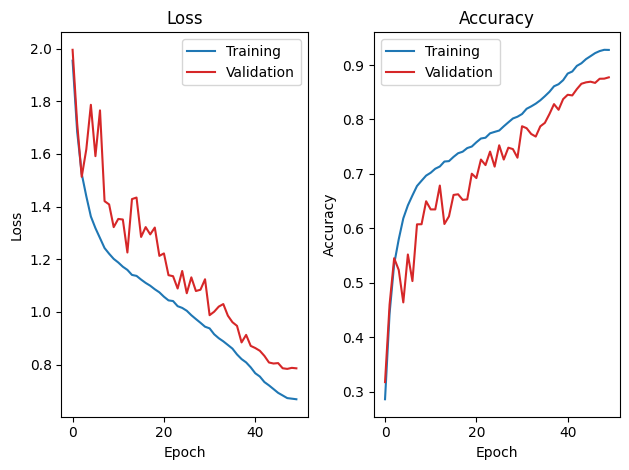

In [5]:
import os
import time

import torch
from torch import nn, optim
from tqdm.notebook import tqdm

reset_seed(10)


def train_one_epoch(model, loader, criterion, optimizer, device=DEFAULT_DEVICE):
    running_loss = 0
    total, correct = 0, 0

    loop = tqdm(loader, desc="Training", leave=True)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = torch.argmax(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix(
            loss=running_loss / (total / images.shape[0]), accuracy=correct / total
        )

    avg_loss = running_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy


def train(
    model,
    trainloader,
    valloader,
    criterion,
    optimizer,
    scheduler=None,
    epochs=1,
    save_path=None,
    early_stop_patience=5,
    device=DEFAULT_DEVICE,
):
    model = model.to(device)

    train_loss, train_acc = [], []
    val_loss, val_acc = [], []

    best_val_acc = 0.0
    early_stop_count = 0

    epoch_loop = tqdm(range(epochs), desc="Epochs", leave=True)

    for epoch in epoch_loop:
        model.train()
        _train_loss, _train_acc = train_one_epoch(
            model, trainloader, criterion, optimizer
        )
        train_loss.append(_train_loss)
        train_acc.append(_train_acc)

        model.eval()
        _val_loss, _val_acc, _ = evaluate(model, valloader, criterion)
        val_loss.append(_val_loss)
        val_acc.append(_val_acc)

        print(f"Epoch {epoch + 1:2d}/{epochs}", end="  ")
        if scheduler is not None:
            print(f"lr={scheduler.get_last_lr()[0]:.2e}", end=", ")
        print(f"train_loss={_train_loss:.4f}, val_loss={_val_loss:.4f}", end=", ")
        print(f"train_acc={_train_acc:.4f}, val_acc={_val_acc:.4f}")


        # 若當前驗證準確率超越最佳值則儲存模型
        if _val_acc >= best_val_acc:
            best_val_acc = _val_acc
            early_stop_count = 0  # 重置 patience 計數器
            if _val_acc >= max(val_acc):
                save_model(model, save_path, existed="overwrite")
        else:
            early_stop_count += 1
            print(f"No improvement for {early_stop_count} epoch(s).")

        # 若超過 patience，則提前停止訓練
        if early_stop_count >= early_stop_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break
        

        if scheduler is not None:
            scheduler.step()

        epoch_loop.set_postfix(
            train_loss=_train_loss,
            val_loss=_val_loss,
            train_acc=_train_acc,
            val_acc=_val_acc,
        )

    return train_loss, train_acc, val_loss, val_acc


def main(epochs, network, dataset, name=None):
    dataset = dataset.lower()
    if name is None:
        name = f"{dataset}/{network.__name__.lower()}"

    t = time.time()
    trainloader, valloader, testloader = DATALOADERS[dataset](batch_size=64)
    in_channels, in_size = trainloader.dataset[0][0].shape[:2]
    model = network(in_channels, in_size).to(DEFAULT_DEVICE)
    #########Implement your code here##########
    #Loss function
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    #Optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    #Scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
    ##########################################
    train_loss, train_acc, val_loss, val_acc = train(
        model,
        trainloader,
        valloader,
        criterion,
        optimizer,
        scheduler,
        epochs,
        save_path=f"weights/{name}.pt",
        early_stop_patience=10,  # 若驗證準確率 10 個 epoch 無提升則提前結束
    )

    test_loss, test_accuracy, _ = evaluate(model.eval(), testloader, criterion)
    print(f"Test: loss={test_loss:.4f}, accuracy={test_accuracy:.4f}")
    print(f"Model size: {os.path.getsize(f'weights/{name}.pt') / 1e6:.2f} MB")

    plot_loss_accuracy(train_loss, train_acc, val_loss, val_acc, f"figure/{name}.png")
    print(f"Time: {time.time() - t:.2f}s")


if __name__ == "__main__":
    for network in [VGG]:
        """ You can adjust the number of epochs """
        EPOCHS = 50
        main(epochs=EPOCHS, network=network, dataset="cifar10")



### PTQ on VGG Model

#### You can refer to 'Quantization in Practice' in the lab material.



In [6]:
import os
import torch
from torch import nn
import torch.ao.quantization as tq

reset_seed(0)

#########Implement your code here##########
""" Calibrate Method """
def calibrate(model, loader, device=DEFAULT_DEVICE):
    model.eval().to(device)   
    for x, _ in loader:       
        model(x.to(device))  
        break                 

###########################################

def main(network, verbose=True):

    #########Implement your code here##########
    """ Calibration """

    """ Calibration Data """
    dataset = 'cifar10'
    backend = 'power2'
    model_path = 'weights/cifar10/vgg.pt'
    *_, test_loader = DATALOADERS[dataset](batch_size=1)
    in_channels, in_size = trainloader.dataset[0][0].shape[:2]
    """ Load Pretrained Model """
    fmodel = network(in_channels, in_size).eval().cpu()
    fmodel.load_state_dict(torch.load(model_path))
    """ Fuse Modules """
    # fmodel = load_model(network(in_channels, in_size), model_path, qconfig = None, fuse_modules= False)
    fmodel.fuse_modules()
    """ Configure Quantization """
    fmodel = tq.QuantWrapper(fmodel)  
    fmodel.qconfig = CustomQConfig.POWER2.value
    print(f"Quantization backend: {fmodel.qconfig}")
    
    """ Apply Quantization """
    tq.prepare(fmodel, inplace=True)
    calibrate(fmodel, test_loader, "cpu") 

    """ Convert Model """
    tq.convert(fmodel.cpu(), inplace=True)

    """ Save Model """
    save_model(fmodel, "weights/cifar10/vgg-power2.pt", existed="overwrite")
    ###########################################


if __name__ == "__main__":
    main(network=VGG, verbose=True)



Files already downloaded and verified
Files already downloaded and verified


C:\Users\Administrator\AppData\Local\Temp\ipykernel_26788\1024425284.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fmodel.load_state_dict(torch.load(model_path))


Quantization backend: QConfig(activation=functools.partial(<class '__main__.PowerOfTwoObserver'>, dtype=torch.quint8, qscheme=torch.per_tensor_symmetric){}, weight=functools.partial(<class '__main__.PowerOfTwoObserver'>, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric){})
Model saved at weights/cifar10/vgg-power2.pt (1.48893 MB)


### Evaluate Quantized Model


In [7]:
import os
from torch import nn
import torch.ao.quantization as tq

reset_seed(0)

def main():
    dataset = 'cifar10'
    backend = 'power2'
    model_path = './weights/cifar10/vgg-power2.pt'

    *_, test_loader = DATALOADERS[dataset](batch_size=1000)
    in_channels, in_size = test_loader.dataset[0][0].shape[:2]
    if backend:
        qconfig = CustomQConfig[backend.upper()].value
        fuse_modules = True
    else:
        qconfig = None
        fuse_modules = False
    model = load_model(VGG(in_channels, in_size), model_path, qconfig=qconfig, fuse_modules=fuse_modules)
    print(model)

    device = "cpu" if backend else DEFAULT_DEVICE
    criterion = nn.CrossEntropyLoss()
    test_loss, test_accuracy, _ = evaluate(
        model.to(device), test_loader, criterion, device=device
    )
    print(
        f"Test: loss={test_loss:.4f}, accuracy={test_accuracy:.4f}, size={os.path.getsize(model_path) / 1e6}MB"
    )


if __name__ == "__main__":
    main()



Files already downloaded and verified
Files already downloaded and verified
Fusing modules
Model loaded from ./weights/cifar10/vgg-power2.pt (1.48893 MB)
QuantWrapper(
  (quant): Quantize(scale=tensor([0.0156]), zero_point=tensor([128]), dtype=torch.quint8)
  (dequant): DeQuantize()
  (module): VGG(
    (conv1): Sequential(
      (0): QuantizedConvReLU2d(3, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.015625, zero_point=128, padding=(1, 1))
      (1): Identity()
      (2): Identity()
      (3): QuantizedConvReLU2d(32, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.015625, zero_point=128, padding=(1, 1))
      (4): Identity()
      (5): Identity()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): QuantizedConvReLU2d(32, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.015625, zero_point=128, padding=(1, 1))
      (1): Identity()
      (2): Identity()
      (3): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), s

C:\Users\Administrator\AppData\Local\Temp\ipykernel_26788\2912952992.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename, map_loc

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Test: loss=0.4812, accuracy=0.8917, size=1.48893MB
